<a href="https://colab.research.google.com/github/aklekowski/agh-mpr/blob/main/OpenMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [MPR] OpenMP

**Adam Klekowski, Paweł Kruczkiewicz**

In [ ]:
import pandas as pd
import matplotlib as plt

### A. Rozkład generatora liczb losowych

Przy użyciu generator liczb losowych `erand48` wygenerowano i zapisano do pliku 1 000 000 wartości. Następnie narysowano histogram uzyskanych wartości dla 10 przedziałów (kolor czerwony) oraz 100 przedziałów (kolor niebieski).

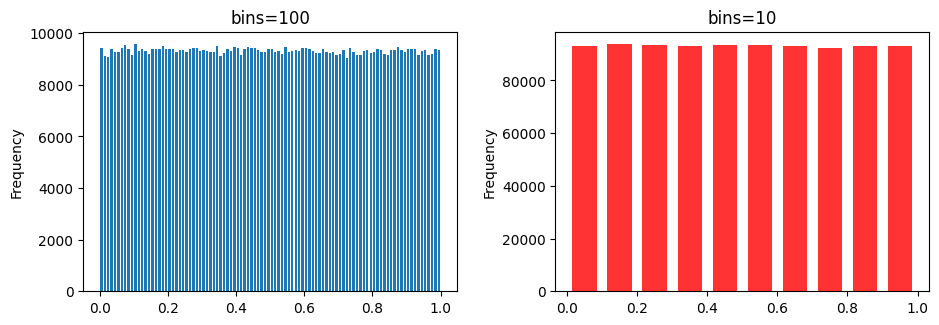

In [ ]:
erand48_df = pd.read_csv("erand48_test.csv")

fig, ((ax1, ax2)) = plt.pyplot.subplots(1, 2)
fig.set_size_inches(10, 4)
fig.tight_layout(pad=4.0)

_ = erand48_df.plot.hist(ax=ax1, bins=100, rwidth=.7, legend=None, title='bins=100')
_ = erand48_df.plot.hist(ax=ax2, bins=10, rwidth=.7, legend=None, color='red', alpha=0.8, title='bins=10')

Generator `erand48` losuje wartości równomiernie z całego przedziału [0.0, 1.0).

## B. Badanie klauzulu `schedule` na pętli `for`
Sprawdzono zrównoleglanie pętli for dla różnych parametrów schedule, tj. typu  (`static`, `dynamic` i `guided`) oraz wielkości parametruchunk.

### Opis środowiska badawczego
Pomiarów dokonano na maszynie vCluster na 4 rdzeniach procesora.

W pliku `bucket_sort.c` dołączonym w systemie UPEL znajduje się kod wykonujący przypisanie liczb losowych w pętli for z wykorzystaniem openMP. Kod wykonano:

- dla 3 różnych wielkości problemu: 1000000 10000000 100000000
- dla 3 różnych typów schedule'owania
- dla 4 wartości parametru chunk: domyślna, 1, 10, 100
we wszystkich wymienionych wyżej konfiguracjach.

Dla łatwiejszego zweryfikowania błędów pomiarowych, każdą z powyższych konfiguracji uruchomiono 20-krotnie i uśredniono wynik.

Powyższe uzyskano dzięki skryptowi for_loop_test.sh zamieszczonym na platformie UPEL. Wynikiem działania programu jest plik CSV, który został użyty w niniejszym sprawozdaniu.

### Analiza wyników

In [ ]:
def load_data_and_aggregate(filename):
    data = pd.read_csv(filename)
    data["CHUNK_SIZE"] = data["CHUNK_SIZE"].map(lambda x: "default" if x == -1 else x).astype("category")
    
    return data
    
def aggr_by_size_sch_chunk(data):
    return data.groupby(["ARR_SIZE", "SCHEDULE_TYPE", "CHUNK_SIZE"])["TIME"].aggregate(["mean", "std"])
    
def aggr_by_size_sch(data):
    return data.groupby(["ARR_SIZE", "SCHEDULE_TYPE"])["TIME"].aggregate(["mean", "std"])
    
for_loop_data = load_data_and_aggregate("for_loop_results.csv")

### Bez podziału na różne wartości parametru `chunk`

In [ ]:
aggreg_data_without_chunks = aggr_by_size_sch(for_loop_data)
aggreg_data_without_chunks

mean       std
ARR_SIZE  SCHEDULE_TYPE                    
4000000   dynamic        0.026008  0.018917
          guided         0.003728  0.000202
          static         0.005467  0.002748
40000000  dynamic        0.228351  0.177817
          guided         0.029276  0.002085
          static         0.035685  0.003201
400000000 dynamic        2.232435  1.719322
          guided         0.308482  0.013963
          static         0.347067  0.030289

### Z podziałem na różne wartości parametru `chunk`

In [ ]:
aggreg_data_with_chunks = aggr_by_size_sch_chunk(for_loop_data)
aggreg_data_with_chunks

mean       std
ARR_SIZE  SCHEDULE_TYPE CHUNK_SIZE                    
4000000   dynamic       1           0.044767  0.002236
                        10          0.009750  0.000435
                        100         0.004947  0.000515
                        default     0.044568  0.002075
          guided        1           0.003793  0.000179
                        10          0.003713  0.000189
                        100         0.003730  0.000188
                        default     0.003674  0.000241
          static        1           0.005181  0.000681
                        10          0.005320  0.001544
                        100         0.007675  0.004468
                        default     0.003693  0.000201
40000000  dynamic       1           0.374268  0.015122
                        10          0.073958  0.000614
                        100         0.034021  0.000412
                        default     0.431155  0.026259
          guided        1           0.027529  0.001067
                        10          0.030663  0.001649
                        100         0.031477  0.000471
                        default     0.027434  0.000312
          static        1           0.039016  0.000543
                        10          0.037941  0.000423
                        100         0.034773  0.000471
                        default     0.031011  0.001002
400000000 dynamic       1           3.798852  0.173575
                        10          0.718607  0.004061
                        100         0.367181  0.016829
                        default     4.045099  0.380173
          guided        1           0.308580  0.017195
                        10          0.305284  0.003009
                        100         0.315825  0.020476
                        default     0.304240  0.000434
          static        1           0.375991  0.000474
                        10          0.363456  0.000900
                        100         0.334338  0.000521
                        default     0.314484  0.036903

Dla klarowności powyższe dane przedstawiono również w formie wykresu. Najpierw porównano różne typy schedulowania (bez podziału na chunki).



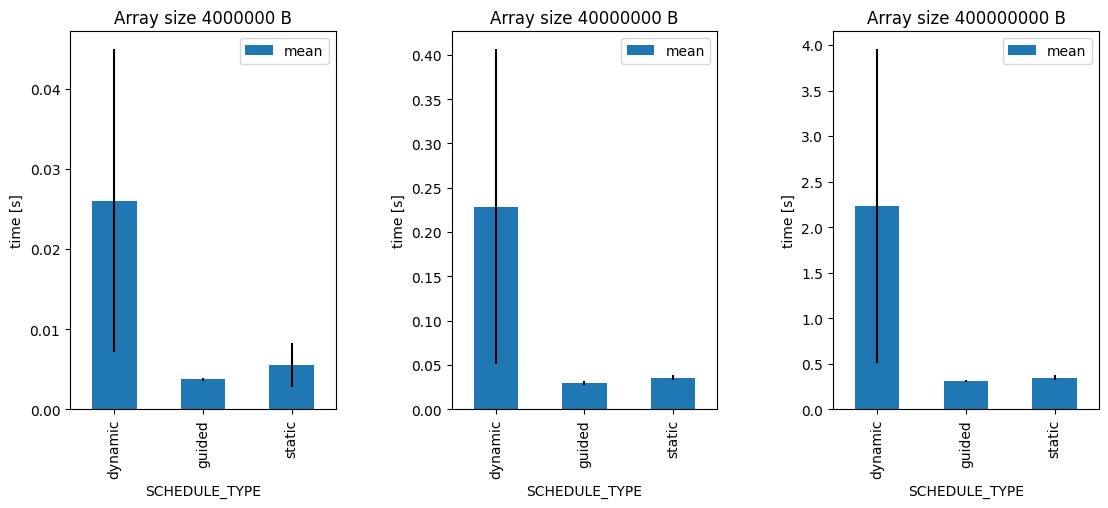

In [ ]:
def plot_for_loop_data_without_chunks(agg_data, arr_sizes):
    fig, axs = plt.pyplot.subplots(1, 3, figsize=(12, 6))
    for ax, arr_size in zip(axs, arr_sizes):
        heights = agg_data.loc[(arr_size,)]
        heights.plot.bar(y="mean", ax=ax, title=f"Array size {arr_size} B", yerr="std", ylabel='time [s]')
    fig.tight_layout(pad=4.0)
    
arr_sizes = for_loop_data["ARR_SIZE"].unique()
plot_for_loop_data_without_chunks(aggreg_data_without_chunks, arr_sizes)

Z powyższego wykresu wyraźnie widzimy, że `guided` jest zdecydowanie najlepszym trybem schedule'owania dla przedstawionego problemu. Końcowa implementacja będzie zatem zawierać ten typ schedule'owania jako domyślny.

Zdecydowanie najgorszy okazał się być typ schedule'owania `dynamic`. Było to do przewidzenia, ponieważ w tak prostym problemie jak zapisywanie liczb zmiennoprzecinkowych do tablicy zaawansowany scheduling taki jak `dynamic` nie jest potrzebny.

Sprawdźmy też, jaki jest najlepszy parametr `chunk` dla tego typu.

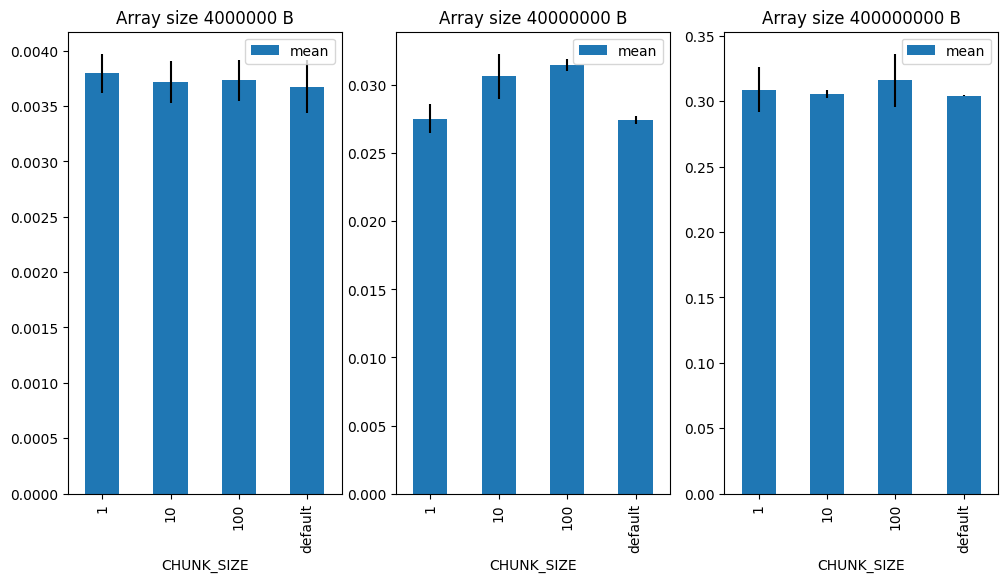

In [ ]:
def plot_for_loop_data_with_chunks(agg_data, arr_sizes, schedule_type):
    fig, axs = plt.pyplot.subplots(1, 3, figsize=(12, 6))
    for ax, arr_size in zip(axs, arr_sizes):
        heights = agg_data.loc[(arr_size, schedule_type)]
        heights.plot.bar(y="mean", ax=ax, title=f"Array size {arr_size} B", yerr="std")   
    
arr_sizes = for_loop_data["ARR_SIZE"].unique()
schedule_chunks = for_loop_data["SCHEDULE_TYPE"].unique()
plot_for_loop_data_with_chunks(aggreg_data_with_chunks, arr_sizes, "guided")

Dla każdego zestawu danych najlepszym rozmiarem chunku okazał się być domyślny. Jest to najprawdopodobniej spowodowane najbardziej sprawiedliwym zrównoważeniem wątków.

### Wnioski
Najlepszym trybem schedule'owania dla problemu zapisywania liczb w pętli `for` okazał się być `guided` z domyślnymi parametrami. Powodu można doszukać się w dobrze napisanym przez twórców implementacji load-balancingu dla wielu wątków w przypadku tego schedule'owania.

## C. Dobór wielkości kubełka
Pomiarów dokonano na maszynie Ares na 1 rdzeniu procesora.
Wykonano po 20 pomiarów dla wielkości problemu równej 10 000 000 i różnej  liczbie koszyków (50 000 - 100 000). Wyniki dla każdej konfiguracji uśredniono.

In [ ]:
bucket_sort_df = pd.read_csv("bucket_sort_seq.csv")
bucket_sort_df = bucket_sort_df.loc[bucket_sort_df['P'] == 1]
bucket_sort_df = bucket_sort_df[['N', 'B', 'T_E']].groupby(by=["N", "B"]).mean()
bucket_sort_df.head(20)

T_E
N        B               
10000000 10000   1.427257
         20000   1.459803
         30000   1.566381
         40000   2.096512
         50000   2.855779
         60000   2.288349
         70000   2.134387
         80000   2.206294
         90000   2.488254
         100000  3.042307

In [ ]:
bucket_sort_df = bucket_sort_df.reset_index()

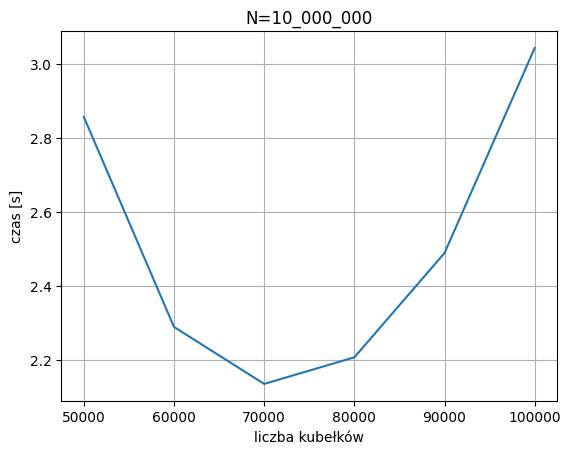

In [ ]:
ax = bucket_sort_df.loc[(bucket_sort_df['N'] == 10_000_000) & (bucket_sort_df['B'] >= 50_000)][['B', 'T_E']].set_index('B').plot(legend=None, title="N=10_000_000", grid='both', ylabel='czas [s]', xlabel='liczba kubełków')

Najszybszy czas sortowania uzyskano dla liczby kubełków równej 70 000, co przekłada się na rozmiar kubełka ok. 143.

## D. Opis algorytmów równoległych

Oba algorytmy zostały napisane w języku C. Użytymi strukturami danych są dynamiczne tablice dostępne w standardowej implementacji języka C. Do sortowania pojedynczych kubełków użyto algorytmu `qsort` dostępnego w bibliotece standardowej języka C.

### Algorytm 1 (Paweł Kruczkiewicz)
Główną cechą algorytmu #1 jest przypisanie do każdego wątku osobnych kubełków w sposób  równomierny. Jego główną trudność następuje w końcowej fazie algoytmu, tzn. w trakcie scalania, kiedy to należy obliczyć indeksy początkowe i końcowe, do których dany wątek powinien wpisać zawartość swoich posortowanych kubełków.

#### Szczegóły implementacji

Został zaimplementowany z użyciem jednej sekcji `#omp parallel`, ponieważ czas na synchronizację wątków byłby kosztowny dla przedstawionego krótkiego algorytmu.

W algorytmie nalezy wykonać sporo obliczeń osobnych dla każdego wątku, tj. zakres obsługiwanych przezeń liczb oraz zakres indeksów kubełków. 

Nieuniknioną stratą dla złożoności równoległego algorytmu jest sczytywanie wartości z tablicy początkowej. Niestety, w tej wersji algorytmu każdy z wątków musi przejść równolegle po całej talblicy wejściowej. Wpływa to znacząco na skalowalność algorytmu. 

Problem scalania przedstawiony w punkcie wyżej rozwiązano poprzez wyliczenie tablicy skumulowanych sum liczby elementów w poszczególnych kubełkach. Przed wyliczeniem tablicy zastosowano barierę, bez której możliwe byłoby dokonywanie obliczeń na niepoprawnej tablicy z liczbą elementów w kubełkach. Jest to kolejne wąskie gardło algorytmu. <br> Tablica jest obliczana dla każdego wątku osobno, bez użycia klauzuli `#omp single`. Jest to kozystniejsze niż przerywanie bloku `#opm parallel` , obliczenie wartości, a następnie rozpoczęcie kolejnego bloku, jednak ma to negatywny wpływ na *prądożerność* naszego algorytmu, o czym również należy pamiętać :)

**Dokładne przedstawienie działania opisanego wyżej algorytmu wraz z opisem poszczególnych jego składowych jak i porównaniem wydajności z przedstawionym niżej algorytmem, zostały przedstawione w punkcie D niniejszego sprawozdania** 

Pełna implementacja znajduje się w pliku [`bucket_sort_par_1.c`](https://github.com/pkrucz00/parallel-programming/blob/openmp/openmp/lab3/bucket_sort_par_1.c).

#### Odpowiedzi na często zadawane pytania
*Czy potrzebna jest jakaś ochrona danych wspólnych (tablica początkowa: przy odczycie i przy zapisie; kubełki: przy zapisie, sortowaniu  kubełka, odczycie)?*

Nie jest potrzebna ochrona danych wspólnych, ponieważ każdy wątek pokrywa przestrzeń indeksów kubełków oraz zakresów wejściowych w sposób kompletny i nie nachodzący.

Odczyt z tablicy początkowej jest zrealizowany poprzez wyliczenie offsetu dla kazdego kubełka.

*Jaki jest rząd złożoności obliczeniowej algorytmu, a jaka jest praca algorytmu równoległego, czy algorytm jest sekwencyjnie-efektywny?*

Sam rząd złożoności algorytmu przy założeniu stałego czasu sortowania kubełków wynosi `O(N)`.
Praca algorytmu, ze względu na niefortunne sczytywanie z tablicy, wynosi `O(N*P)`.
Algorytm nie jest zatem sekwencyhnie-efektywny, ponieważ algorytm równoległy potrzebuje sumarycznie wykonać więcej operacji niż prosty algorytm sekwencyjny (musi sczytać N elementową tablicę P razy).

### Algorytm 2 (Adam Klekowski)
Algorytm #2 zaimplmentowano z użyciem 1 sekcji `#omp parallel`. Poszczególne częsci algorytmu (wypełnienie tablicy, rozdział do kubełków, sortowanie kubełków, scalanie) zrównoleglono przy użyciu `omp for` z typem schedul\`owania `guided` i domyślną wartością parametru `chunk`.

Przed scalaniem konieczne jest wyliczenie indeksów, gdzie w tablicy należy zacząć wpisywać elementy danego kubełka. Służy do tego funkcja `calculate_cumulative_sum`, której wynik jest współdzielony przez wszystkie procesy. Aby uniknąć niepotrzebnego wywołania tej funkcji przez każdy proces, dodano dyrektywę `#pragma omp single`, dzięki której funkcję wykona pierwszy wolny proces.
```c
    double t_start = omp_get_wtime();
#pragma omp parallel
    {
        int tid = omp_get_thread_num();

        fill_array_randomly(arr, N, tid);
        t_a_arr[tid] = omp_get_wtime();

        distribute_to_buckets(arr, buckets, bucket_ind, bucket_locks);
        t_b_arr[tid] = omp_get_wtime();

        sort_buckets(buckets, bucket_ind);
        t_c_arr[tid] = omp_get_wtime();

#pragma omp single
        cummulative_sum_arr = calculate_cumulative_sum(bucket_ind, B, cummulative_sum_arr);
        merge_buckets(arr, buckets, bucket_ind, cummulative_sum_arr);
    }
    double t_end = omp_get_wtime();
```
Wypełnienie tablicy:
```c
void fill_array_randomly(float* arr, int n, int tid) {
  ...
#pragma omp for private(i) schedule(guided)
    for (i = 0; i < n; i++){
        arr[i] = erand48(xi);
    }
}
```
Rozdział do kubełków:
```c
void distribute_to_buckets(const float* arr, float** buckets, int* bucket_ind,  omp_lock_t* bucket_locks) {
  ...
#pragma omp for private(i, number_of_elements_in_bucket) schedule(guided)
    for (i = 0; i < N; i++) {
        int number_of_bucket = (int) B*arr[i];

        omp_set_lock(&bucket_locks[number_of_bucket]);
        number_of_elements_in_bucket = bucket_ind[number_of_bucket];
        buckets[number_of_bucket][number_of_elements_in_bucket] = arr[i];
        bucket_ind[number_of_bucket]++;
        omp_unset_lock(&bucket_locks[number_of_bucket]);
    }
}
```
Sortowanie kubełków:
```c
void sort_buckets(float** buckets, int* bucket_ind) {
#pragma omp for private(i) schedule(guided)
    for (int i = 0; i < B; i++){
        qsort(buckets[i], bucket_ind[i], sizeof(*(buckets[i])), asc);
    }
}
```
Scalanie:
```c
void merge_buckets(float* arr, float** buckets, const int* bucket_ind, const int* cummulative_sum_arr) {
  ...
#pragma omp for private(i, j, arr_i) schedule(guided)
    for (i=0; i < B; i++) {
        arr_i = i == 0 ? 0 : cummulative_sum_arr[i-1];
        for (j=0; j < bucket_ind[i]; j++) {
            arr[arr_i] = buckets[i][j];
            arr_i ++;
        }
    }
}
```

Implementacja w pliku [`bucket_sort_par_2.c`](https://github.com/aklekowski/agh-mpr/blob/main/src/bucket_sort_par_2.c).

1. Czy potrzebna jest jakaś ochrona danych wspólnych (tablica początkowa: przy odczycie i przy zapisie; kubełki: przy zapisie, sortowaniu  kubełka, odczycie)?

Ochrona pamięci potrzebna jest jedynie podczas zapisu do kubełków.

2. Jaki jest rząd złożoności obliczeniowej algorytmu, a jaka jest praca algorytmu równoległego, czy algorytm jest sekwencyjnie-efektywny?

Rząd złożoności `O(N / P)`. Nie jest sekwencyjnie-efektywny.

## E. Badanie jakości algorytmów równoległych

Pomiarów dokonano na maszynie Ares ([dokumentacja techniczna](https://docs.cyfronet.pl/display/~plgpawlik/Ares)). Ares ma 532 node'y, 48 corów i 192 GB pamięci. Użyto 1 node'a i 12 core`ów. Wykonano po 20 pomiarów dla wielkości problemu równej 10 000 000, liczby koszyków równej 70 000 i liczby proceserów 1 - 12. Wyniki dla każdej konfiguracji uśredniono. Wielkość problemu i liczbę kubełków dobrano na podstawie badań z sekcji C.

In [ ]:
bucket_sort_ver_1 = pd.read_csv("bucket_sort_par_1.csv")
bucket_sort_ver_1.insert(loc=0, column='algorithm ver.', value=1)

bucket_sort_ver_2 = pd.read_csv("bucket_sort_par_2.csv")
bucket_sort_ver_2.insert(loc=0, column='algorithm ver.', value=2)

df = bucket_sort_ver_1.merge(bucket_sort_ver_2, how='outer')
df = df[['algorithm ver.', 'N', 'B', 'P', 'T_A', 'T_B', 'T_C', 'T_D', 'T_E']].groupby(by=['algorithm ver.', "N", "B", "P"]).mean().reset_index()

In [ ]:
df.head()

,algorithm ver.,N,B,P,T_A,T_B,T_C,T_D,T_E
0,1,10000000,70000,1,0.065354,0.323365,0.763430,0.036279,1.188428
1,1,10000000,70000,2,0.033881,0.196542,0.381986,0.018545,0.630954
2,1,10000000,70000,3,0.022728,0.156494,0.254887,0.038619,0.472728
3,1,10000000,70000,4,0.017330,0.138013,0.191043,0.040445,0.386831
4,1,10000000,70000,5,0.014141,0.127282,0.152883,0.041503,0.335809


Legenda:

N - rozmiar problemu

B - liczba kubełków

P - liczba procesorów

T_A - czas wypełniania tablicy

T_B - czas sczytawania tablicy początkowej

T_C - czas sortowania

T_D - czas scalania

T_E - czas całkowity


### E1. Czas sortowania w zależności od liczby procesorów

In [ ]:
common_config = {'ylim': (0, 1.7), 'grid':'both', 'legend': None, 'width': 0.2, 'xlabel': 'liczba procesorów', 'ylabel': 'czas [s]'}

def plot_total_time(df, ax, al_ver, col):
  return df.loc[(df['algorithm ver.'] == al_ver) & (df['N'] == 10_000_000) & (df['B'] == 70_000)][['P', 'T_E']].set_index('P').plot.bar(ax=ax, stacked=True, title='Czas całkowity', position=2-al_ver, color=col, **common_config)

def plot_compontents_time(df, ax, al_ver, col):
  return df.loc[(df['algorithm ver.'] == al_ver) & (df['N'] == 10_000_000) & (df['B'] == 70_000)][['P', 'T_A', 'T_B', 'T_C', 'T_D']].set_index('P').plot.bar(ax=ax, stacked=True, position=2-al_ver, title='Czasy cząstkowe', **common_config)

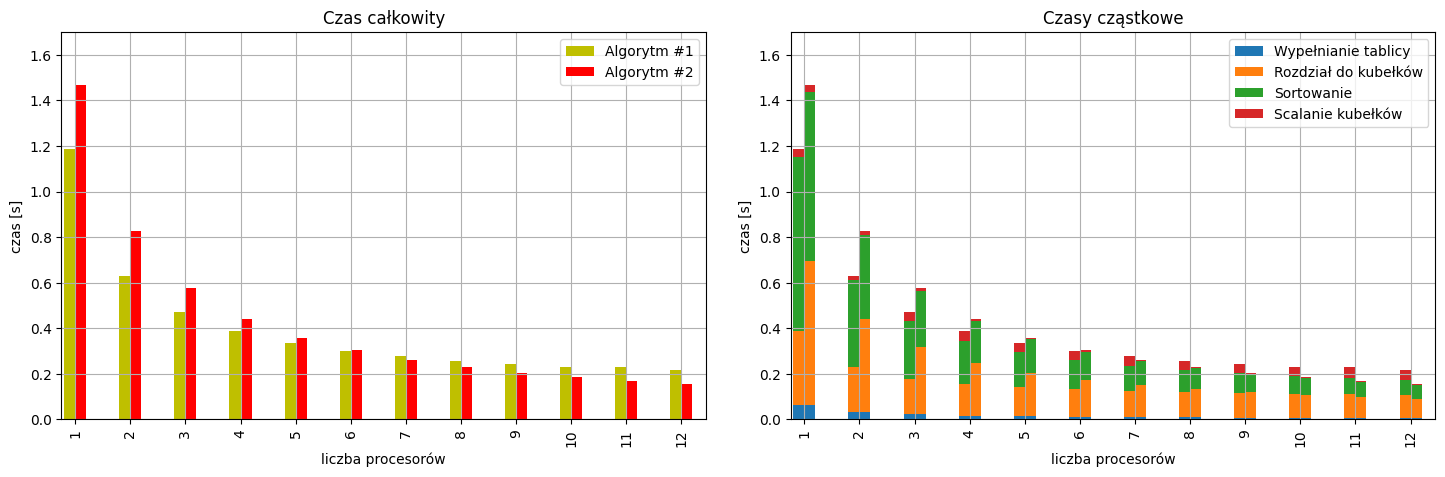

In [ ]:
fig, ((ax1, ax2)) = plt.pyplot.subplots(1, 2)
fig.set_size_inches(15, 5)
fig.tight_layout(pad=3.0)

for i in range(12):
  plot_total_time(df, ax1, 1, 'y')
  plot_total_time(df, ax1, 2, 'r')
_ = ax1.legend(['Algorytm #1', 'Algorytm #2'])

for i in range(12):
  plot_compontents_time(df, ax2, 1, 'y')
  plot_compontents_time(df, ax2, 2, 'r')
_ = ax2.legend(['Wypełnianie tablicy', 'Rozdział do kubełków', 'Sortowanie', 'Scalanie kubełków'])

### Wnioski
Algorytm #2 - mimo że cechuje się większym czasem sortowania dla 1 procesora, osiąga dla wielu wątków zdecydowanie lepsze wyniki czasowe od implementacji algorytmu #1. Można wnioskować, że algorytm #2 zrównolegla się lepiej.

Patrząc na czasy cząstkowe można zauważyć, że dla obu algorytmów czas sortowania się zmniejsza wraz ze wzrostem liczby procesorów. Jest to porządana cecha charakterystyczna dla poprawnej implementacji algorytmu kubełkowego.

*Wąskie gardła* wspomniane w opiesie algorytmu #1 w części C (tj. rodział do kubełków oraz ich scalanie) są widoczne na wykresie czasów cząstkowych. Odpowiadające im czasy składowe dla algorytmu #2 zrónoleglają się zdecydowanie lepiej.

### E2. Przyspieszenie w zależności od liczby procesorów
**DO POMIARÓW PRZYŚPIESZENIA OBU ALGORYTMÓW UŻYTO PRAWA AMDAHLA**

In [ ]:
df_1 = df.loc[(df['N'] == 10_000_000) & (df['B'] == 70_000) & (df['algorithm ver.'] == 1)].copy()
for value in ['T_A', 'T_B', 'T_C', 'T_D', 'T_E']:
  value_1 = df_1.iloc[0][value]
  df_1[f"speedup_{value}"] = value_1 / df_1[value]
df_1.head()

,algorithm ver.,N,B,P,T_A,T_B,T_C,T_D,T_E,speedup_T_A,speedup_T_B,speedup_T_C,speedup_T_D,speedup_T_E
0,1,10000000,70000,1,0.065354,0.323365,0.763430,0.036279,1.188428,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,10000000,70000,2,0.033881,0.196542,0.381986,0.018545,0.630954,1.928946,1.645268,1.998583,1.956223,1.883541
2,1,10000000,70000,3,0.022728,0.156494,0.254887,0.038619,0.472728,2.875488,2.066309,2.995175,0.939398,2.513978
3,1,10000000,70000,4,0.017330,0.138013,0.191043,0.040445,0.386831,3.771222,2.343003,3.996123,0.896983,3.072216
4,1,10000000,70000,5,0.014141,0.127282,0.152883,0.041503,0.335809,4.621512,2.540547,4.993559,0.874116,3.538998


In [ ]:
df_2 = df.loc[(df['N'] == 10_000_000) & (df['B'] == 70_000) & (df['algorithm ver.'] == 2)].copy()
for value in ['T_A', 'T_B', 'T_C', 'T_D', 'T_E']:
  value_1 = df_2.iloc[0][value]
  df_2[f"speedup_{value}"] = value_1 / df_2[value]
df_2.head()

,algorithm ver.,N,B,P,T_A,T_B,T_C,T_D,T_E,speedup_T_A,speedup_T_B,speedup_T_C,speedup_T_D,speedup_T_E
12,2,10000000,70000,1,0.064876,0.628882,0.741334,0.032318,1.467410,1.000000,1.000000,1.000000,1.000000,1.000000
13,2,10000000,70000,2,0.033311,0.405731,0.370910,0.016510,0.826462,1.947560,1.549998,1.998690,1.957489,1.775532
14,2,10000000,70000,3,0.022543,0.294380,0.247188,0.011251,0.575362,2.877848,2.136292,2.999069,2.872504,2.550411
15,2,10000000,70000,4,0.017258,0.230370,0.185941,0.008583,0.442152,3.759194,2.729876,3.986919,3.765530,3.318790
16,2,10000000,70000,5,0.014046,0.189148,0.148661,0.007000,0.358854,4.618752,3.324820,4.986752,4.617145,4.089158


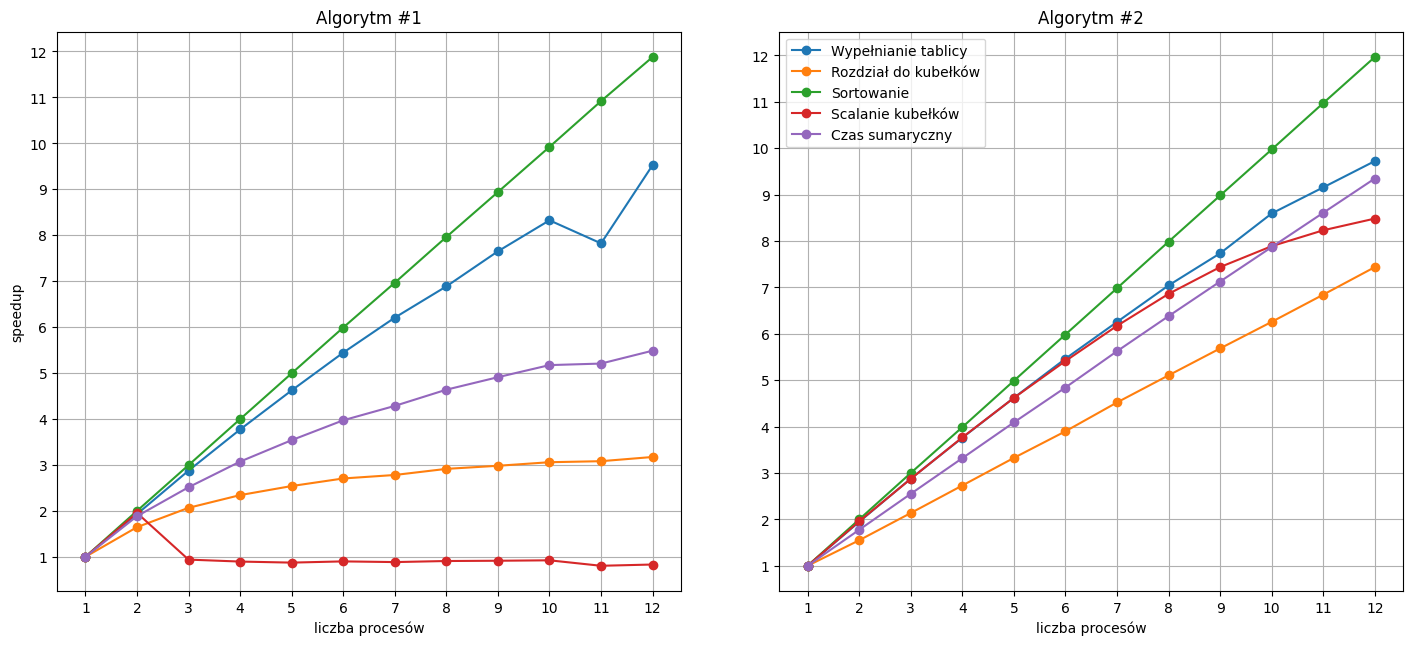

In [ ]:
fig, ((ax1, ax2)) = plt.pyplot.subplots(1, 2)
fig.set_size_inches(15, 7)
fig.tight_layout(pad=4.0)

common_config = {'linestyle': '-', 'marker': 'o', 'x': 'P', 'xticks':range(1, 13, 1), 'yticks':range(1, 13, 1), 'grid':'both'}
for y in ['speedup_T_A', 'speedup_T_B', 'speedup_T_C', 'speedup_T_D', 'speedup_T_E']:
  df_1.plot(ax=ax1, y=y, **common_config, title='Algorytm #1', ylabel="speedup", xlabel="liczba procesów", legend=None)
for y in ['speedup_T_A', 'speedup_T_B', 'speedup_T_C', 'speedup_T_D', 'speedup_T_E']:
  df_2.plot(ax=ax2, y=y, **common_config, title='Algorytm #2', xlabel="liczba procesów")
plt.pyplot.legend(['Wypełnianie tablicy', 'Rozdział do kubełków', 'Sortowanie', 'Scalanie kubełków', 'Czas sumaryczny']);

### Wnioski

Zgodnie z tym, co można zaobserwować na wykresach czasu sortowania, widać, że algorytm #2 cechuje się lepszym przyspieszeniem. Poszczególne składowe algorytmu #2 uzyskują lepsze lub równe wartości przyspieszenia, niż odpowiadające im składowe algorytmu #1.

W obu algorytmach udało się uzyskać przyspieszenie liniowe dla sortowania kubełków. W obu algorytmach wypełnianie tablicy przyspiesza na poziomie ok. 10 dla 12 procesorów. 

W algorytmie #1 katastrofalnie wygląda część scalania kubełków. Jest to ze względu na zastosowaną barierę zasadniczo część sekwencyjna. Speedup tej części oscyluje w okolicy wartości 1, c mogłoby potwierdzać te wnioski.

Równie słabo radzi sobie rozdział do kubełków. Powody słabego przyśpieszenia wspomniano już wcześniej. Fakt, że *pewne* przyśpieszenie (rzędu ok. 3 dla ponad 7 procesorów) można tłumaczyć tym, że każdy wątek ma co prawda wiele operacji sczytywania pamięci, ale ma mniej zapisów (w porównaniu z mniejsza liczbą procesorów).

Na plus można zaliczyć wypełnianie tablicy. Poza jednym spadkiem w okolicy 11 wątków, który najpewniej spowodowany jest krótkotrwałymi problemami ze środowiskiem, ponieważ kod tej części jest identyczny w implementacjach algorytmu #1 i #2.

Ogółem algorytm osiąga lepsze wyniki dla wielu wątków, jednak widać, że przyśpieszenie dla wielu wątków nie będzie od pewnego momentu znacznie rosło wraz ze wzrostem liczby procesorów. Gdybym za każdy dodatkowy procesor należało zapłacić stałą kwotę, to ten algorytm nie zasługiwałby na wielka inwestycję.:)

W algorytmie #2 rozdział do kubełków przyspiesza najwolniej. Jest to spowodowane koniecznością synchronizacji (lock`ów) wątków. Scalanie kubełków jako jedyne nie ma liniowej charakterystyki. Jest to spodowane koniecznością wyliczenia indeksów ("gdzie dany wątek ma zacząć wpisywanie danego kubełka"), co wprowadza element sekwencyjny do obliczeń.